In [1]:
from io import StringIO
from html.parser import HTMLParser     
        
class StackOverflowParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.strict = False # If any invalid html is encountered, parser will make a best guess at its intention
        self.convert_charrefs= True # Hold data section until next tag is encountered
        
        # Field variable to keep track of parsed data with tags removed
        self.text = StringIO()
        self.text_no_code = StringIO()
        
        # Field variables to keep track of and store <code></code> blocks
        self.code_blocks = []
        self.lasttag = None
        
    def handle_starttag(self, tag, attrs):
        '''
        Method inherited from HTMLParser super class that is called whenever the start of a tag is encountered.
        In this parser, it keeps track of the last start tag that was encountered.
        :param tag: Current tag being parsed (ex: p, div, code, etc.)
        :type tag: str
        :param attrs: List of (name,value) pairs containing attributes found inside the tag's brackets
        :type attrs: list[str]
        '''
        assert isinstance(tag,str)
        assert isinstance(attrs, list) 
        
        self.lasttag = tag
        
    def handle_data(self, data): 
        '''
        Method inherited from HTMLParser super class that is called whenever data inside of a tag is encountered.
        In this parser, it saves blocks of code to the field variable self.code and records all text with HTML tags removed
        :param data: Current data inside of a tag being parsed
        :type tag: str
        '''
        assert isinstance(data,str)
        
        # If the last tag encountered was a <code> tag, append the contents to the list of code blocks
        if self.lasttag == "code":
            self.lasttag = None
            self.code_blocks.append(data)
        else:  
            self.text_no_code.write(data)
            
        # Record text between tags
        self.text.write(data)
        
    def get_data(self):
        '''
        Returns parsed text without HTML tags 
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text.getvalue()
    
    def get_data_no_code(self):
        '''
        Returns parsed text without HTML tags and with code blocks removed
        :return: Text wihtout tags
        :type return: str
        '''
        return self.text_no_code.getvalue()
    
def strip_tags(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags
    :type return: str
    '''
    assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data()

def get_text_no_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the same text with the HTML tags and blocks of code now removed. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the parsed output.
    :param html: HTML-formatted body of text
    :type html: str
    :return: The input text now without HTML tags or code blocks
    :type return: str
    '''
    assert isinstance(html,str)
    
    # Feed text into parser and return parsed text without tags
    s = StackOverflowParser()
    s.feed(html)
    return s.get_data_no_code()

def get_code(html):
    '''
    Takes in a body of text that is formatted in HTML and returns the blocks of code found within the text. 
    This method bundles the process of instantiating a parser, feeding the data, and returning the blocks of code.
    An empty list is returned if no <code> tags are found.
    :param html: HTML-formatted body of text
    :type html: str
    :return: List of blocks of code found within text
    :type return: list[str]
    '''
    assert isinstance(html,str)
    
    s = StackOverflowParser()
    s.feed(html) 
    return [item.replace('\n', ' ') for item in s.code_blocks]
            

In [2]:
import pandas as pd

# File paths
file_questions = 'Questions.csv'
file_answers = 'Answers.csv'

# Load dataframes (only loading first 10000 rows for now to reduce processing time)
questions_df = pd.read_csv(file_questions, nrows=10000, encoding = 'iso-8859-1')
answers_df = pd.read_csv(file_answers, nrows=10000, encoding = 'iso-8859-1')

In [3]:
# Add extra columns to dataframes
# This takes a long time (~10 minutes) to process the entire dataset
# Might be worth exploring the pandas to_pickle() method for saving/loading the dataframes
questions_df['Body_no_tags_no_code']=questions_df['Body'].apply(get_text_no_code)

In [4]:
questions=questions_df['Body_no_tags_no_code']

In [5]:
import numpy as np
import seaborn as sns # Import seaborn for visualization
import matplotlib.pyplot as plt
sns.set()

In [6]:
import nltk # Import natural language toolkit library
nltk.download('stopwords')
import pyLDAvis #Import pyLDAvis for interactive visualization
import pyLDAvis.gensim
import gensim #Import gensim for topic modelling 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy #Import Spacy for lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [7]:
data=list(questions) # Insert the question into list

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Create bigram and trigram sequences
bigram = gensim.models.Phrases(data, min_count=20, threshold=100) 
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import en_core_web_sm  #English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = en_core_web_sm.load()

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Load tagger
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk fro preprocessing
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """
    Transform the  questions into lowercase, build bigrams-trigrams, and apply lemmatization

    """
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
processed_data = process_words(data) #Apply processing functions to the list


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
id2word = corpora.Dictionary(processed_data) # Create dictionary of the words 
print('Vocabulary Size:', len(id2word))

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Vocabulary Size: 15935


In [13]:
corpus = [id2word.doc2bow(text) for text in processed_data] #Create Cprpus tuple (BoW format) containing the each word id and their frequency


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
#Create dictionary and dataframe of Corpus to remove the high frequncy words 
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
dict_df

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,freq
actual,207
api,378
correspond,93
font,39
guess,273
...,...
pete,13
gql,18
forbid,10
tom,12


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


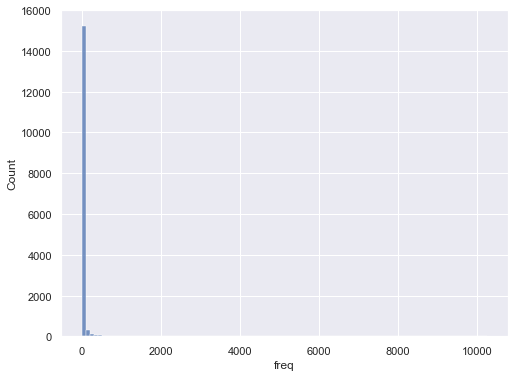

In [16]:
# Plot histogram of word frequency 
plt.figure(figsize=(8,6))
sns.histplot(dict_df['freq'], bins=100);

In [73]:
#Top 25 high-frequency words
dict_df2=dict_df.sort_values('freq', ascending=False).head(25) 

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
dict_df2

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,freq
python,10256
use,8730
get,4447
file,4351
way,4238
code,3956
want,3647
work,3413
try,3301
run,2629


In [71]:
# Filter out high-frequancy words based on the pre-defined threshold
extension = dict_df[dict_df.freq>1788].index.tolist()


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# List of other non-relevant words identified by inspection that need to be filterd out
unrelevant=['problem', 'good', 'lot', 'people', 'great', 'problem', 'answer', 'question', 'solution', 'wrong', 'prefer', 'mention', 'correctly', 'good', 'easy', 'follow', 'great', 'feel', 'idea', 'recommend', 'support', 'pretty', 'result', 'basic', 'give', 'bad', 'nice', 'try', 'well', 'write', 'look']

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Add non-relevant words to high-frequncy words
extension.extend(unrelevant)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Add high-frequency and nor-relevant words to stop words list
stop_words.extend(extension)
# Rerun the word processing function
processed_data= process_words(data)
# Recreate Dictionary
id2word = corpora.Dictionary(processed_data)
print('New Vocabulary Size:', len(id2word))

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


New Vocabulary Size: 15931


In [22]:
# Filter out words that occur on less than 10 questions, or on more than 60% of the questions.
id2word.filter_extremes(no_below=10, no_above=0.6)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 2604


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Update the corpus 
corpus = [id2word.doc2bow(text) for text in processed_data]

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
import os
from gensim.models.wrappers import LdaMallet  # Import Mallet LDA
num_topics=25 # Number of Topics

# Path to Mallet
os.environ['MALLET_HOME'] = 'C:\\new_mallet\\mallet-2.0.8' 
mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet'

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Built the topic model using Mallet LDA implementation
ldamallet =gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Print the topics compiled by the model and diplay 5 term and their relative weights
from pprint import pprint
pprint(ldamallet.show_topics(num_words=5,formatted=False))

[(8,
  [('window', 0.13117709437963945),
   ('library', 0.13001060445387064),
   ('system', 0.04209968186638388),
   ('linux', 0.04019088016967126),
   ('standard', 0.028525980911983034)]),
 (15,
  [('test', 0.1214514652014652),
   ('method', 0.09615384615384616),
   ('generate', 0.06421703296703296),
   ('xml', 0.04624542124542125),
   ('documentation', 0.04063644688644689)]),
 (12,
  [('page', 0.0826),
   ('html', 0.0779),
   ('http', 0.0595),
   ('url', 0.0566),
   ('post', 0.0475)]),
 (6,
  [('number', 0.10678271945653328),
   ('point', 0.06411209001167605),
   ('loop', 0.038212503980469166),
   ('element', 0.03757562891412801),
   ('index', 0.02441354420974419)]),
 (2,
  [('database', 0.09111301004058962),
   ('table', 0.07124546037171545),
   ('query', 0.05533005767998291),
   ('update', 0.04475539414654988),
   ('row', 0.03578295236060671)]),
 (3,
  [('app', 0.13755646375564637),
   ('project', 0.0801247580124758),
   ('build', 0.07722090772209077),
   ('engine', 0.0395784039578

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Compute the Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.43159854157711386


In [30]:
# Build another model using multicore LDA implementation and compare the coherence score
from gensim.models import LdaMulticore
ldamulticore = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word,workers=4, eval_every=None, passes=20, batch=True,)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Display topics
pprint(ldamulticore.show_topics(num_words=5,formatted=False))

[(17,
  [('server', 0.035507545),
   ('php', 0.034496788),
   ('language', 0.019995024),
   ('web', 0.018863421),
   ('perl', 0.016860215)]),
 (9,
  [('xml', 0.03859208),
   ('server', 0.021840572),
   ('apache', 0.020975474),
   ('document', 0.014965575),
   ('time', 0.013944642)]),
 (12,
  [('test', 0.08745552),
   ('module', 0.03824257),
   ('import', 0.03686342),
   ('project', 0.024080586),
   ('unit', 0.016725292)]),
 (7,
  [('image', 0.092171386),
   ('save', 0.019115042),
   ('color', 0.014946161),
   ('datum', 0.014259217),
   ('pil', 0.014199923)]),
 (18,
  [('array', 0.045383662),
   ('date', 0.02804069),
   ('number', 0.019745499),
   ('numpy', 0.018328918),
   ('java', 0.015016438)]),
 (14,
  [('method', 0.052959777),
   ('instance', 0.033286817),
   ('attribute', 0.017918242),
   ('define', 0.013729875),
   ('access', 0.010394298)]),
 (22,
  [('error', 0.036586065),
   ('window', 0.031224696),
   ('instal', 0.021726988),
   ('module', 0.021007895),
   ('version', 0.020326

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Compute Coherence Score for the multicore model
coherence_model_ldamulticore = CoherenceModel(model=ldamulticore, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamulticore = coherence_model_ldamulticore.get_coherence()
print('Coherence Score: ', coherence_ldamulticore)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.4394025440465335


In [39]:
# Build another model using LDA implementation and compare the coherence score with the two previous models
from gensim.models import LdaModel
ldamodel = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, eval_every=None, passes=20,)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# Display topics
pprint(ldamodel.show_topics(num_words=5,formatted=False))

[(6,
  [('query', 0.055741668),
   ('set', 0.02886333),
   ('record', 0.025341522),
   ('update', 0.020761704),
   ('database', 0.017065141)]),
 (3,
  [('page', 0.08838641),
   ('url', 0.048839275),
   ('post', 0.044520304),
   ('request', 0.036024034),
   ('html', 0.03432577)]),
 (19,
  [('key', 0.07956867),
   ('dictionary', 0.06353572),
   ('match', 0.04049726),
   ('expression', 0.030866548),
   ('regular', 0.024208976)]),
 (9,
  [('test', 0.16223384),
   ('unit', 0.027794078),
   ('fail', 0.026482455),
   ('check', 0.02332275),
   ('testing', 0.016269514)]),
 (16,
  [('form', 0.084050246),
   ('display', 0.050704528),
   ('text', 0.042149037),
   ('widget', 0.029525893),
   ('button', 0.029176572)]),
 (2,
  [('string', 0.15317841),
   ('character', 0.046884466),
   ('convert', 0.042002816),
   ('encode', 0.02305571),
   ('unicode', 0.022281744)]),
 (0,
  [('language', 0.02993972),
   ('php', 0.027031602),
   ('application', 0.026337523),
   ('web', 0.024858141),
   ('framework', 0

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=ldamodel, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('Coherence Score: ', coherence_ldamodel)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.43904390542020294


In [42]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """ function to plot difference between modelsUses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
try:
    get_ipython()
    import plotly.offline as py
except Exception:

    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


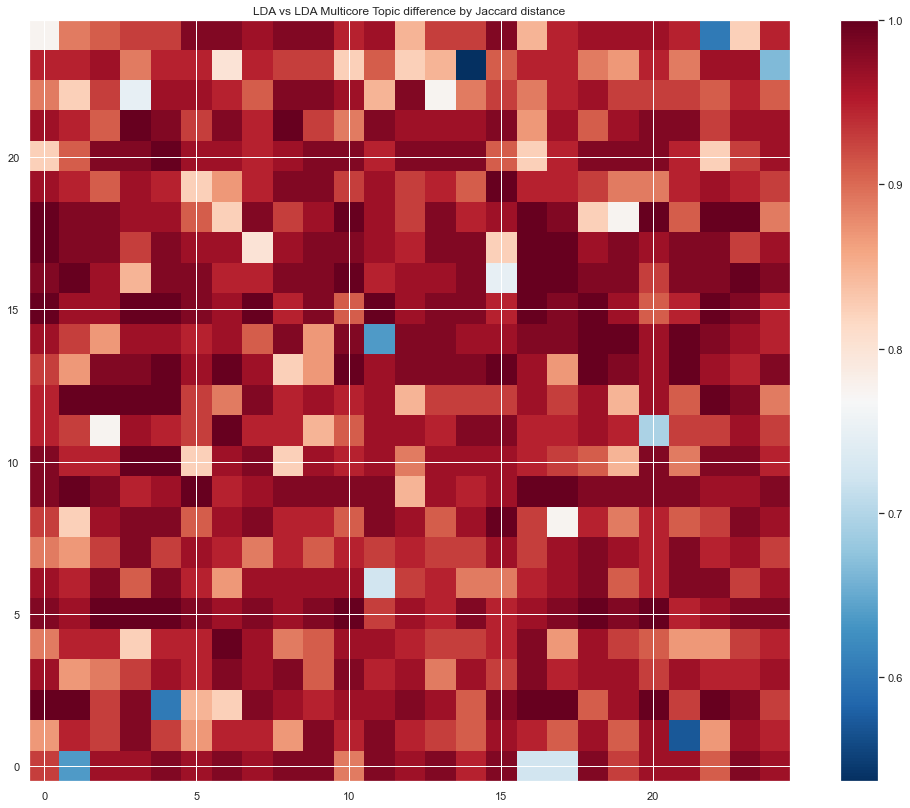

In [43]:
# Heatmap to compare the correlation between LDA and Multicore LDA
mdiff, annotation = ldamodel.diff(ldamulticore, distance='jaccard', num_words=30)
plot_difference(mdiff, title="LDA vs LDA Multicore Topic difference by Jaccard distance", annotation=annotation)

In [44]:
# Convert LdaMallet model to a gensim model for Visualization

from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
ldagensim = convertldaMalletToldaGen(ldamallet)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


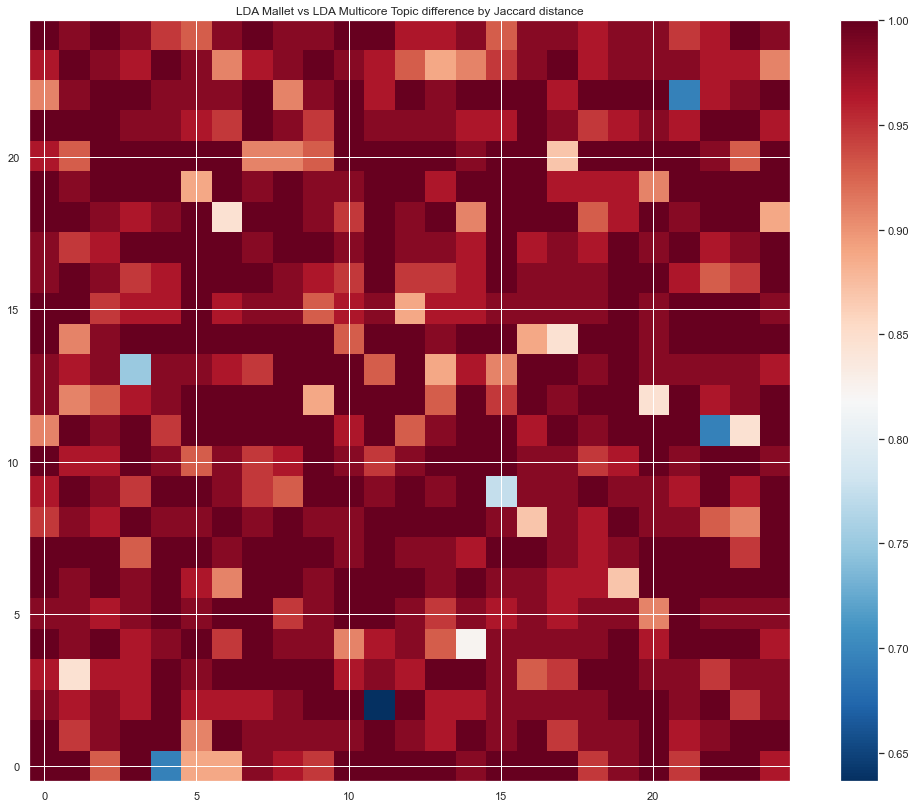

In [46]:
# Heatmap to compare the correlation between LDA and Multicore LDA
mdiff, annotation = ldagensim.diff(ldamulticore, distance='jaccard', num_words=30)
plot_difference(mdiff, title="LDA Mallet vs LDA Multicore Topic difference by Jaccard distance", annotation=annotation)

In [47]:
# Get the topic distributions by passing in the corpus to the model
tm_results = ldamallet[corpus]

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Get the most dominant topic
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Get top  significant terms and their probabilities for each topic  
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# 5 most probable words for each topic
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
Term1,string,bit,database,app,type,message,number,check,window,thread,...,test,module,application,return,search,server,time,process,set,line
Term2,convert,thing,table,project,method,send,point,exception,library,program,...,method,error,option,key,match,image,long,command,change,text
Term3,format,end,query,build,instance,simple,loop,case,system,main,...,generate,import,require,pass,array,web,date,program,variable,edit
Term4,character,start,update,engine,define,information,element,open,linux,event,...,xml,log,api,dictionary,word,client,assume,output,access,remove
Term5,input,part,row,google,attribute,email,index,exist,standard,display,...,documentation,fine,interface,argument,expression,php,day,print,add,output


In [53]:
# Display all the terms for each topic
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-30e7d5be79f1>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"string, convert, format, character, input, parse, encode, unicode, read, extract, integer, byte, split, return, int, utf, binary, parser, ascii, represent"
Topic2,"bit, thing, end, start, part, read, put, simple, place, issue, stuff, thought, hope, delete, title, separate, tutorial, play, back, piece"
Topic3,"database, table, query, update, row, column, mysql, select, entry, insert, record, sql, sqlite, store, statement, sqlalchemy, retrieve, edit, access, orm"
Topic4,"app, project, build, engine, google, start, tool, update, resource, include, thing, manage, report, task, develop, kind, advance, regard, appengine, put"
Topic5,"type, method, instance, define, attribute, tag, suppose, base, foo, specific, common, case, context, bar, member, understand, provide, constructor, definition, subclass"
Topic6,"message, send, simple, information, email, receive, implement, figure, address, node, tree, account, graph, domain, core, root, pdf, deal, simply, actual"
Topic7,"number, point, loop, element, index, algorithm, step, map, filter, random, range, generator, count, game, calculate, solve, sequence, position, simple, efficient"
Topic8,"check, exception, case, open, exist, handle, java, level, correct, close, reason, reference, guess, understand, state, happen, raise, block, catch, statement"
Topic9,"window, library, system, linux, standard, interpreter, platform, share, extension, win, compile, machine, computer, filename, zip, open, wrapper, unix, mac, cross"
Topic10,"thread, program, main, event, display, gui, widget, button, wxpython, click, show, control, move, signal, handler, box, queue, lock, draw, frame"


D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


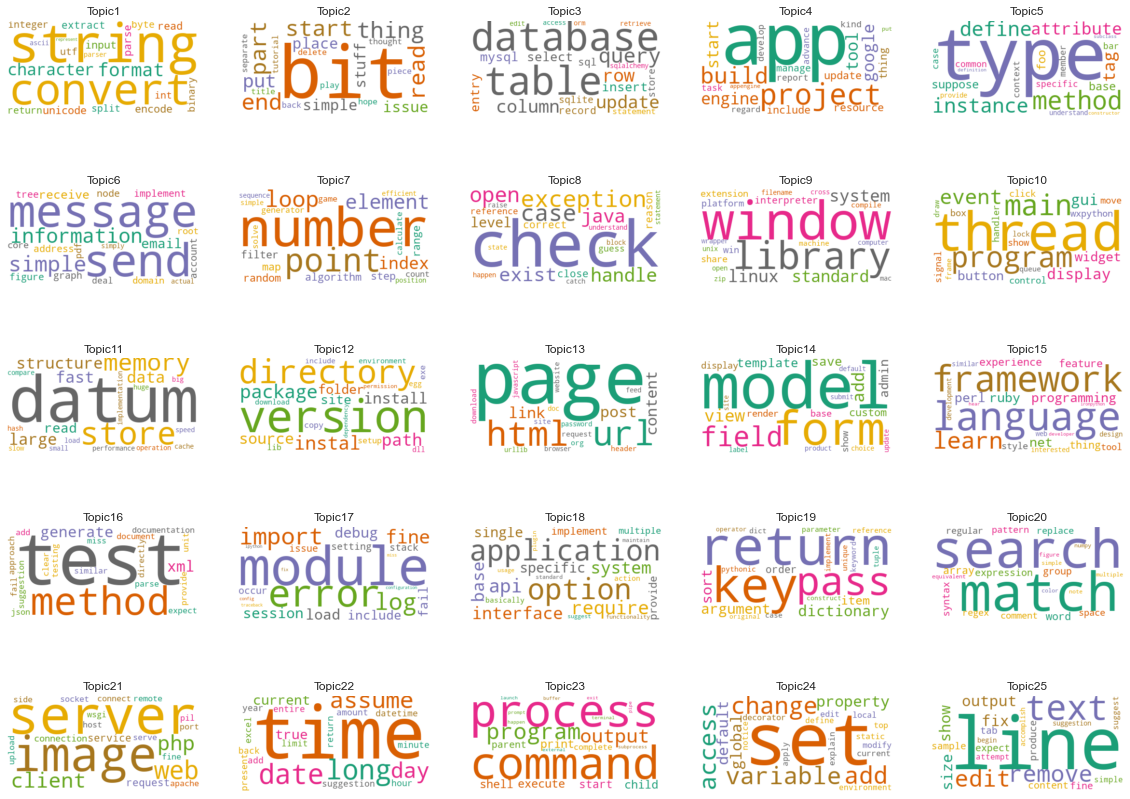

In [57]:
# Visualize the LDA Mallet terms as wordclouds
from wordcloud import WordCloud # Import wordclouds

# Initiate the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(25):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [55]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

D:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
